# Train and Fine-Tune Sentence Transformers Models - Notebook Companion

In [1]:
%%capture
!pip install sentence-transformers

## How Sentence Transformers models work

## Sentence transformers

Questo notebook è stato eseguito online su Google Colab.

[GitHub](https://github.com/huggingface/blog/blob/main/how-to-train-sentence-transformers.md)

[Colab](https://colab.research.google.com/drive/1gQzKs_8UwwlsoSGBddOZ58QVhecVcG33?usp=sharing)

Un modello Sentence Transformer model è tale per cui si **mappa** del testo di lunghezza arbitraria (ma anche un'immagine, se è per questo) in un **embedding** di taglia prefissata, il quale è inteso describa il significato di quel testo.


Ecco come funzionano i modelli Sentence Transformers:

* Livello 1 – Il testo in ingresso viene passato attraverso un modello Transformer **pre-addestrato** che può essere scaricato direttamente da Hugging Face Hub. Questa guida utilizzerà il modello "distilroberta-base". I risultati del Transformer sono **contextualized word embeddings** per ognuno degli input token. In questa fase quindi si hanno molti vettori, uno per ogni token del testo, e non uno solo.
* Livello 2 - Gli embedding passano attraverso uno strato di **pooling** per ottenere un singolo embedding di lunghezza fissa, usato per rappresentare tutto il testo. Ad esempio, il **mean pooling** calcola la media degli embedding generati dal modello.

---

This Python code is part of a tutorial demonstrating how to use the `SentenceTransformer` library to create embeddings for sentences using pre-trained language models. Let's break down each step:

1. **Importing Necessary Modules**: The code begins by importing required modules from the `sentence_transformers` package. This package is used for generating sentence embeddings.

2. **Step 1: Using an Existing Language Model**: The first step involves selecting a pre-trained language model. In this case, it's using the `distilroberta-base` model. This model is a distilled version of the RoBERTa model, which is a variant of the BERT model. The `models.Transformer()` function initializes the transformer model.

3. **Step 2: Using a Pool Function over Token Embeddings**: After initializing the transformer model, the code initializes a **pooling model**. Pooling is a technique used to condense the information from the token embeddings (word embeddings) into a fixed-length vector that represents the entire sentence. Here, it seems to be using a pooling model with the same dimensionality as the word embeddings.

4. **Joining Steps 1 and 2 Using the Modules Argument**: Finally, the code combines the word embedding model and the pooling model into a single `SentenceTransformer` model. This is done by passing both models as a list to the `modules` parameter of the `SentenceTransformer` constructor.

In summary, this code sets up a pipeline for generating sentence embeddings using a transformer-based language model (`distilroberta-base`) followed by a pooling layer to condense the token embeddings into fixed-length sentence embeddings. The resulting model (`SentenceTransformer`) can then be used to generate embeddings for input sentences.


In [2]:
from sentence_transformers import SentenceTransformer, models

## Step 1: use an existing language model
word_embedding_model = models.Transformer('distilroberta-base')

## Step 2: use a pool function over the token embeddings
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

## Join steps 1 and 2 using the modules argument
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Osserviamo da quanto fatto che i modelli Sentence Transformers sono composti da **moduli**, ossia una lista di layers che sono eseguiti consecutivamente. Il testo di input entra nel primo modulo, e l'output finale esce dall'ultima componente. L'architettura a due moduli realizzata qui sopra è in realtà piuttosto tipica, sebbene layer ulteriori possono essere creati all'evenienza.

Uno potrebbe chiedersi, a questo punto, perché non usare un BERT o un Roberta già preallenati per creare gli embedding dell'intera sequenza direttamente, invece che usarlo solo per il primo modulo generando embeddings per i singoli token. Vi sono 2 ragioni:

1. I transormers pre-trained richiedono molta computazione per eseguire un task di *semantic search*. Trovare la coppia di frasi più simili in una collezione di 10K frasi complessive richiede un totale di circa 50 milioni di inferenze, e quindi 65 ore, se si usa BERT. In contrasto, un BERT Sentence Transformer model riduce questo tempo a **5 secondi**.
2. Una volta allenati, i transformer possono creare delle rappresentazioni vettoriali per le frasi che possono essere, generalmente, piuttosto povere. Infatti, un modello BERT i cui embedding creati per i token e messi in media performa peggio che il modello statico GloVe del 2014.

Vediamo qui prima come creare un Sentence Transformer model da 0. Successivamente, se si volesse fare il fine tuning di un Sentence Transformer Model, si potrà scaricare un modello da HF e lavorare su quello. Tali modelli si trovano nel task di HF [Sentence Similarity](https://huggingface.co/models?pipeline_tag=sentence-similarity). Di seguito vediamo il loading di un modello scaricato direttamente da HF.

## Preparare il dataset per allenare un Sentence Transformers model

Per addestrare un modello di Sentence Transformers, devi informarlo in qualche modo di quando due frasi hanno un certo grado di **similarità**. Pertanto, ogni esempio nei dati richiede un'etichetta o una struttura che consenta al modello di capire se due frasi sono simili o diverse.

Purtroppo, non esiste un unico modo per preparare i dati per addestrare un modello di Sentence Transformers. Dipende in larga misura dai tuoi obiettivi e dalla struttura dei tuoi dati. Se non hai un'etichetta esplicita, che è lo scenario più probabile, puoi derivarla dal design dei documenti da cui hai ottenuto le frasi. Ad esempio, due frasi nello stesso rapporto dovrebbero essere più confrontabili di due frasi in rapporti diversi. Le frasi adiacenti potrebbero essere più confrontabili di quelle non adiacenti.

Inoltre, la **struttura dei dati** influenzerà la loss function che puoi utilizzare.

La maggior parte delle configurazioni del dataset assumerà una delle quattro forme:

* Caso 1: L'esempio è una **coppia di frasi** e un'**etichetta** che indica *quanto sono simili*. L'etichetta può essere un intero o un float, ossia un numero che indica l'intensità con cui i due sono simili. Questo caso si applica ai dataset originariamente preparati per il task *Natural Language Inference* (NLI), poiché contengono coppie di frasi con un'etichetta che indica se si inferiscono l'un l'altra o no.
* Caso 2: L'esempio è una **coppia di frasi positive** (simili) ma *senza etichetta*. Ad esempio, delle **coppie di parafrasi**, coppie composte da un **testo completo e il suo riassunto**, coppie di **domande duplicate**, coppie di **(query, risposta)** o coppie di **(lingua_sorgente, lingua_destinazione)**. I dataset di Natural Language Inference possono essere formattati anche accoppiando **frasi che si inferiscono a vicenda**. Avere i dati in questo formato può essere ottimo, poiché puoi utilizzare la funzione di perdita `MultipleNegativesRankingLoss`, una delle funzioni di perdita più utilizzate per i modelli di Sentence Transformers.
* Caso 3: L'esempio è **una frase** con **un'etichetta intera** (un numero intero). Questo formato di dati è facilmente convertito dalle funzioni di perdita in tre frasi (triplette) dove la prima è un **"ancoraggio"**, la seconda una **"positiva"** della stessa classe dell'ancoraggio e la terza una **"negativa"** di una classe diversa. Ogni frase ha un'etichetta intera che indica la classe a cui appartiene.
* Caso 4: L'esempio è una tripletta **(ancoraggio, positiva, negativa)**, **senza classi** o etichette per le frasi.

Qui addestriamo un Sentence Transformer utilizzando un dataset nel quarto caso. Lo perfezionerai quindi utilizzando la configurazione del dataset del secondo caso.

Si noti che i modelli Sentence Transformers possono essere addestrati con etichettatura umana (casi 1 e 3) o con etichette automaticamente dedotte dalla formattazione del testo (principalmente caso 2; sebbene il caso 4 non richieda etichette, è più difficile trovare dati in una tripletta a meno che non li elabori come fa la funzione MegaBatchMarginLoss).

Sul Hub di Hugging Face ci sono dataset per ognuno dei casi sopra elencati. Inoltre, i dataset sul Hub hanno una funzionalità di Anteprima del Dataset che consente di visualizzare la struttura dei dataset prima di scaricarli. Ecco alcuni set di dati di esempio per ognuno di questi casi:

* Caso 1: La stessa configurazione di Natural Language Inference può essere utilizzata se hai (o produci) un'etichetta che indica il grado di similarità tra due frasi; ad esempio {0,1,2} dove 0 è contraddizione e 2 è implicazione. Esamina la struttura del dataset SNLI.
* Caso 2: Il dataset di Sentence Compression ha esempi composti da coppie positive. Se il tuo dataset ha più di due frasi positive per esempio, ad esempio quintetti come nei dataset COCO Captions o Flickr30k Captions, puoi formattare gli esempi per avere diverse combinazioni di coppie positive.
* Caso 3: Il dataset TREC ha etichette intere che indicano la classe di ogni frase. Ogni esempio nel dataset Yahoo Answers Topics contiene tre frasi e un'etichetta che indica il suo argomento; pertanto, ogni esempio può essere diviso in tre.
* Caso 4: Il dataset Quora Triplets ha triplette (ancoraggio, positiva, negativa) senza etichette.

Il passaggio successivo è convertire il dataset in un formato che il modello di Sentence Transformers possa comprendere. Il modello non può accettare elenchi grezzi di stringhe. Ogni esempio deve essere convertito in una classe `sentence_transformers`.InputExample e quindi in una classe torch.utils.data.DataLoader per raggruppare e mescolare gli esempi.

Installa Hugging Face Datasets con `pip install datasets` o con poetry. Quindi importa un dataset con la funzione `load_dataset`:

In [3]:
%%capture
!pip install datasets

In [4]:
from datasets import load_dataset

dataset_id = "embedding-data/QQP_triplets"
# dataset_id = "embedding-data/sentence-compression"

dataset = load_dataset(dataset_id)

Generating train split: 0 examples [00:00, ? examples/s]

The MultipleNegativesRankingLoss, also known as **Triplet Loss**, is a loss function commonly used in training neural networks for tasks like similarity learning, image retrieval, and recommendation systems. Its primary objective is to learn embeddings (or representations) of input data such that semantically similar instances are closer together in the embedding space, while dissimilar instances are farther apart.

Here's how the MultipleNegativesRankingLoss works:

1. **Triplet Setup**: The loss function operates on triplets of data points. Each triplet consists of an anchor data point, a positive data point, and a negative data point. The anchor and positive data points are considered similar, while the anchor and negative data points are considered dissimilar.

2. **Embedding Space**: The model learns to map each data point (e.g., image, text) into a high-dimensional embedding space. The goal is to learn embeddings such that the distance between the anchor and positive data points is minimized, while the distance between the anchor and negative data points is maximized.

3. **Loss Calculation**: For each triplet, the loss function calculates the difference between the distances of the anchor and positive pairs (referred to as the positive loss) and the distances of the anchor and negative pairs (referred to as the negative loss). The objective is to minimize the positive loss and maximize the negative loss simultaneously.

4. **Margin Parameter**: To prevent the model from trivially minimizing the loss by collapsing all embeddings to zero, a margin parameter is often introduced. The margin specifies a minimum desired separation between the positive and negative pairs. The loss encourages the positive pairs to be closer together than the negative pairs by at least the margin.

Mathematically, the MultipleNegativesRankingLoss can be expressed as:

$$\mathcal{L} = \sum_{i=1}^{N} \max \left( d(x_i^a, x_i^p) - d(x_i^a, x_i^n) + \text{margin}, 0 \right)$$

Where:
- $N$ is the number of triplets in the batch.
- $x_i^a$, $ x_i^p $, and $ x_i^n $ represent the anchor, positive, and negative embeddings for the $i$-th triplet, respectively.
- $ d(\cdot) $ represents a distance metric in the embedding space, such as Euclidean distance or cosine similarity.
- The loss encourages the positive pairs to have smaller distance than the negative pairs by at least the margin.

By optimizing the network using this loss function, the model learns to produce embeddings that effectively capture the underlying similarity structure of the input data.

In [5]:
print(f"- The {dataset_id} dataset has {dataset['train'].num_rows} examples.")
print(f"- Each example is a {type(dataset['train'][0])} with a {type(dataset['train'][0]['set'])} as value.")
print(f"- Examples look like this: {dataset['train'][0]}")

- The embedding-data/QQP_triplets dataset has 101762 examples.
- Each example is a <class 'dict'> with a <class 'dict'> as value.
- Examples look like this: {'set': {'query': 'Why in India do we not have one on one political debate as in USA?', 'pos': ['Why cant we have a public debate between politicians in India like the one in US?'], 'neg': ['Can people on Quora stop India Pakistan debate? We are sick and tired seeing this everyday in bulk?', 'Why do politicians, instead of having a decent debate on issues going in and around the world, end up fighting always?', 'Can educated politicians make a difference in India?', 'What are some unusual aspects about politics and government in India?', 'What is debate?', 'Why does civic public communication and discourse seem so hollow in modern India?', 'What is a Parliamentary debate?', "Why do we always have two candidates at the U.S. presidential debate. yet the ballot has about 7 candidates? Isn't that a misrepresentation of democracy?", 'Wh

Convert the examples into `InputExample`s. It might around 10 seconds in Google Colab.

Possiamo notare che la anchor `query` è composta da una sola frase. `pos` è invece una lista di frasi considerate esempi positivi, ossia semanticamente vicini alla frase. In questo esempio è solo una, ma in generale è una lista. `neg`, invece, è una lista di frasi negative. Qui ne abbiamo parecchie.

Ora, convertiamo questi esempi che abbiamo scaricato in oggetto `InputExamples`. Per semplicità faremo sì che solo uno degli esempi positivi ed uno di quelli negativi siano inseriti negli embedding data, ossia nelle triplette che saranno usate. Useremo inoltre, per comodità, solo 1/2 dei dati a noi disponibili. Chiaramente, più esempi avremo e migliori saranno i risultati.

---

1. **Importing Necessary Modules**: The code imports the `InputExample` class from the `sentence_transformers` package. This class is typically used to represent training examples for models in the `sentence_transformers` library.

2. **Initializing a List for Training Examples**: A list named `train_examples` is initialized to store training examples.

3. **Extracting Data from a Dataset**: the code expects there to be a variable named `dataset`, which contains training data. It extracts the training data from `dataset['train']['set']`.

4. **Determining the Number of Examples to Use**: The variable `n_examples` is set to half of the total number of rows in the training set of the dataset. This line aims to use only a portion (half) of the available training data for training the model, possibly for efficiency or testing purposes.

5. **Iterating Over the Training Data**: The code iterates through the first `n_examples` from the training data.

6. **Creating Input Examples**: For each iteration, it retrieves an example from the training data at index `i`. It then constructs an `InputExample` object using the `InputExample` class constructor. This constructor expects a list of texts as input. Here, it constructs an `InputExample` using three texts: the query (`example['query']`), a positive example (`example['pos'][0]`), and a negative example (`example['neg'][0]`). These texts are likely to be strings representing sentences or documents.

7. **Appending Input Examples to the List**: The constructed `InputExample` object is appended to the `train_examples` list.

In summary, this code snippet is responsible for extracting training examples from a dataset, possibly for training a model later. It constructs `InputExample` objects using these examples and stores them in a list named `train_examples`. Each `InputExample` contains a query text, a positive example, and a negative example. This setup is commonly used in tasks like training Siamese neural networks for tasks such as sentence similarity or information retrieval.

In [6]:
from sentence_transformers import InputExample

train_examples = []
train_data = dataset['train']['set']
# For agility we only 1/2 of our available data
n_examples = dataset['train'].num_rows // 2

for i in range(n_examples):
  example = train_data[i]
  train_examples.append(InputExample(texts=[example['query'], example['pos'][0], example['neg'][0]]))

In [7]:
print(f"We have a {type(train_examples)} of length {len(train_examples)} containing {type(train_examples[0])}'s.")

We have a <class 'list'> of length 50881 containing <class 'sentence_transformers.readers.InputExample.InputExample'>'s.


We wrap our training dataset into a Pytorch `Dataloader` to shuffle examples and get batch sizes.

---

This continuation of the code is setting up a PyTorch `DataLoader` for the training examples. Let's break it down:

1. **Importing Necessary Modules**: The code imports the `DataLoader` class from `torch.utils.data`. This class is used to load data in batches during the training process, which is essential for training deep learning models efficiently.

2. **Initializing a DataLoader**: The `DataLoader` is initialized with the training examples `train_examples`. This creates an iterable dataset from which batches of data can be loaded.

3. **Shuffling the Data**: The `shuffle=True` argument indicates that the data should be shuffled before each epoch. Shuffling the data helps in preventing the model from learning the order of the examples and can improve the generalization of the model.

4. **Specifying Batch Size**: The `batch_size=16` argument specifies that each batch loaded by the `DataLoader` will contain 16 training examples. Batch size is a hyperparameter that determines the number of examples processed in parallel during each training iteration. Larger batch sizes can lead to faster training times but require more memory.

In summary, this code sets up a PyTorch `DataLoader` for the training examples. The DataLoader will shuffle the data and load it in batches of size 16 during the training process, which is a common practice in deep learning. This DataLoader can then be used in the training loop to iterate over batches of training data for training the model.

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

## Funzioni di loss per allenare un Sentence Transformers model

Ricordiamo che ci sono **quattro diversi formati** in cui potrebbero trovarsi i nostri dati. Ognuno di questi formati ha associata una diversa funzione di perdita.

Caso 1: Coppia di frasi e un'etichetta che indica quanto sono simili. La funzione di perdita ottimizza affinché (1) le frasi con le etichette più vicine siano vicine nello spazio vettoriale e (2) le frasi con le etichette più distanti siano il più lontano possibile. La funzione di perdita dipende dal formato dell'etichetta. Se è un intero, utilizza ContrastiveLoss o SoftmaxLoss; se è un float puoi utilizzare CosineSimilarityLoss.

Caso 2: Se hai solo due frasi simili (due positivi) senza etichette, allora puoi utilizzare la funzione di perdita MultipleNegativesRankingLoss. Anche MegaBatchMarginLoss può essere utilizzato, e converrebbe i tuoi esempi in triplette (ancora_i, positivo_i, positivo_j) dove positivo_j funge da negativo.

Caso 3: Quando i tuoi campioni sono triplette della forma [ancora, positivo, negativo] e hai un'etichetta intera per ciascuno, una funzione di perdita ottimizza il modello affinché le frasi ancorate e positive siano più vicine nello spazio vettoriale rispetto alle frasi ancorate e negative. Puoi utilizzare BatchHardTripletLoss, che richiede che i dati siano etichettati con interi (ad esempio, etichette 1, 2, 3) assumendo che campioni con la stessa etichetta siano simili. Pertanto, le ancorate e i positivi devono avere la stessa etichetta, mentre i negativi devono averne una diversa. In alternativa, puoi utilizzare BatchAllTripletLoss, BatchHardSoftMarginTripletLoss o BatchSemiHardTripletLoss. Le differenze tra di loro sono al di là dello scopo di questo tutorial, ma possono essere esaminate nella documentazione di Sentence Transformers.

Caso 4: Se non hai un'etichetta per ciascuna frase nelle triplette, dovresti utilizzare TripletLoss. Questa perdita minimizza la distanza tra le frasi ancorate e positive, mentre massimizza la distanza tra le frasi ancorate e negative.


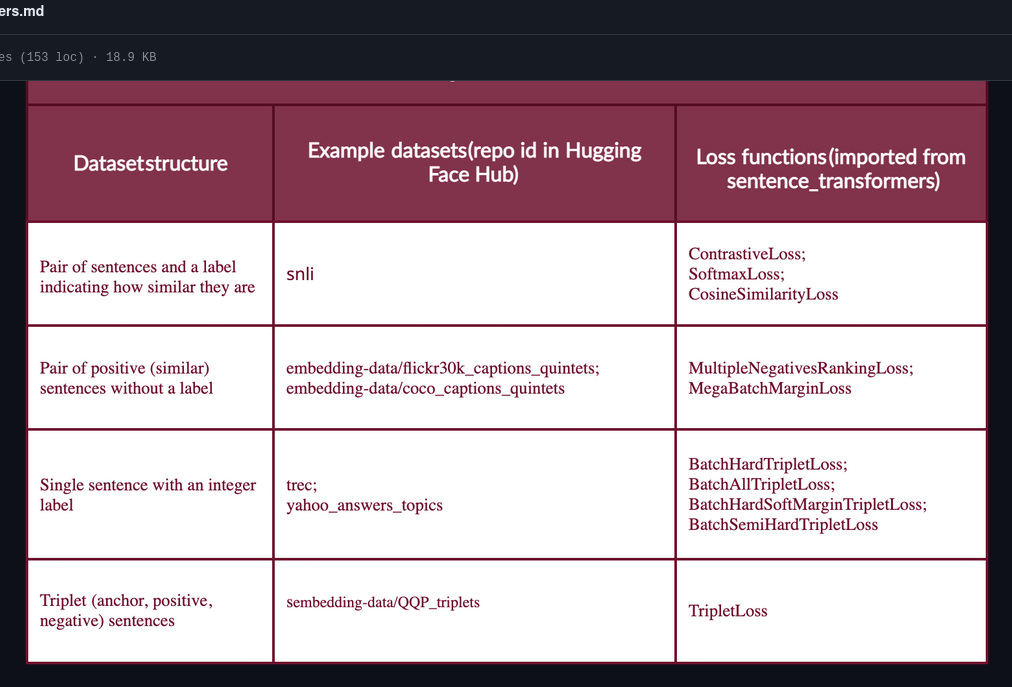

La parte più difficile, osservando la tabella qui sopra, è scegliere una loss function che sia adeguata concettualmente. Dato che siamo nel quarto caso, noi useremo la **TripletLoss**. Come codice, bastano due righe:

---

This continuation of the code is setting up a triplet loss function for training the model. Triplet loss is commonly used in tasks like learning embeddings for similar items (e.g., sentences, images) by ensuring that embeddings of similar items are closer to each other in the embedding space than embeddings of dissimilar items.

Here's what's happening:

1. **Importing Necessary Modules**: The code imports the `TripletLoss` class from the `sentence_transformers.losses` module.

2. **Initializing the Triplet Loss Function**: The `TripletLoss` function is initialized with the `model` argument. This `model` is presumably the `SentenceTransformer` model that was created earlier in the code. The `TripletLoss` function computes the loss based on triplets of examples: an anchor example, a positive example (similar to the anchor), and a negative example (dissimilar to the anchor).

3. **Assigning to `train_loss`**: The initialized `TripletLoss` object is assigned to the variable `train_loss`. This `train_loss` object can then be used during the training process to compute the loss for the model.

In summary, this code sets up a triplet loss function for training the `SentenceTransformer` model. This loss function will be used during the training process to optimize the model's parameters based on the embeddings it generates for triplets of examples (anchor, positive, and negative).

In [9]:
from sentence_transformers import losses

train_loss = losses.TripletLoss(model=model)

## How to train a Sentence Transformer model

La libreria SentenceTransformers è stata creata appositamente per permettere il training e il fine-tuning "facile" dei nostri modelli. Il training di un modello di questo tipo assomiglia a qualcosa del genere:

```python
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=10)
```

Se stiamo facendo fine-tuning, si può chiamare direttamente il metodo `fit`. Diversamente, se è un modello completamente nuovo, serve prima definirlo come si è fatto nella sezione all'inizio. Questo è quanto. Vediamo cosa si può fare.

---

This part of the code is calculating the number of warm-up steps. Warm-up steps are often used in training deep learning models, especially when using techniques like learning rate scheduling, to gradually increase the learning rate from a very small value to the desired value. Here's what's happening:

1. **Setting the Number of Epochs**: `num_epochs` is set to 10, indicating that the model will be trained over 10 epochs. An epoch is a single pass through the entire training dataset.

2. **Calculating Warm-up Steps**: `warmup_steps` is calculated based on the length of the `train_dataloader` (which represents the number of batches in the training data) and the number of epochs. Specifically, it's set to 10% of the total number of steps (`len(train_dataloader) * num_epochs`) rounded to the nearest integer. The value `0.1` represents 10% of the total number of steps.

   Warm-up steps are typically used to gradually increase the learning rate at the beginning of training to allow the model to converge more smoothly. By starting with a smaller learning rate and gradually increasing it, the model can avoid large updates that might destabilize training at the outset.

In summary, this part of the code sets the number of epochs for training (`num_epochs`) and calculates the number of warm-up steps (`warmup_steps`) based on the length of the training dataloader and the specified percentage (10%) of the total number of steps in the training process.

In [10]:
num_epochs = 10

warmup_steps = int(len(train_dataloader) * num_epochs * 0.1) #10% of train steps

Training takes around 45/50 minutes with a Google Colab Pro account. Decrease the number of epochs and examples if you are using a free account or no GPU.

---

The provided code snippet seems to be part of the training process for the model. Let's break it down:

1. **Model Training with `fit` Method**: This code is calling the `fit` method on the `model` object. The `fit` method is commonly used in machine learning libraries like TensorFlow and PyTorch to train models. In this case, it seems to be a method provided by the `SentenceTransformer` library for training models.

2. **Training Objectives**: The `train_objectives` parameter is passed to the `fit` method. It expects a list of tuples, where each tuple contains the training data and the corresponding loss function. In this case, it's specifying that the training objectives consist of one tuple `(train_dataloader, train_loss)`, where `train_dataloader` is the DataLoader containing the training data and `train_loss` is the triplet loss function calculated earlier.

3. **Epochs**: The `epochs` parameter specifies the number of epochs for which the model will be trained. It's set to the value of `num_epochs`, which was defined earlier as 10.

4. **Warm-up Steps**: The `warmup_steps` parameter is also passed to the `fit` method. It determines the number of warm-up steps for the training process. This parameter was calculated earlier based on the length of the training dataloader and the number of epochs.

In summary, this code snippet is responsible for initiating the training process for the model. It specifies the training data, loss function, number of epochs, and warm-up steps, and then starts the training process using the `fit` method. During training, the model will learn to minimize the specified loss function on the provided training data over the specified number of epochs, gradually increasing the learning rate during the warm-up steps.

In [11]:
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3181 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3181 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3181 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3181 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3181 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3181 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3181 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3181 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3181 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3181 [00:00<?, ?it/s]

## How to share a Sentence Transformers to the Hugging Face Hub

In [ ]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your termin

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Una volta fatto login sul nostro account HF inserendo la chiave per la lettura, possiamo usare il `save_to_hub` method per salvare il nostro modello. Di default, il modello è caricato sul nostro account. Possiamo invece caricare, tramite `organization`, sull'account di un'altra organizzazione passando il suo nome.

La funzione `save_to_hub` genera automaticamente una scheda del modello, un widget di inferenza, frammenti di codice di esempio e ulteriori dettagli. Puoi aggiungere automaticamente alla scheda del modello nell'Hub un elenco di dataset utilizzati per addestrare il modello utilizzando l'argomento train_datasets:

In [ ]:
model.save_to_hub(
    "distilroberta-base-sentence-transformer",
    organization="embedding-data",
    train_datasets=["embedding-data/QQP_triplets"],
    exist_ok=True,
    )

## Extra: How to fine-tune a Sentence Transformer model


Now we will fine-tune our Sentence Transformer model.

Let's continue to dissect the code:

1. **Initializing Another Sentence Transformer Model**: This part of the code initializes another instance of the `SentenceTransformer` model. Here, it's loading a pre-trained model named `'distilroberta-base-sentence-transformer'` from the directory `'embedding-data'`. This new model instance is assigned to the variable `modelB`.

2. **Loading Another Dataset**: The code loads another dataset specified by the variable `dataset_id`, which is set to `'embedding-data/sentence-compression'`. The `load_dataset()` function is used to load the dataset.

3. **Printing an Example**: After loading the dataset, the code prints an example from the training set of the dataset.

In summary, this part of the code initializes another `SentenceTransformer` model (`modelB`) with a different pre-trained model and loads another dataset (`datasetB`) related to sentence compression. Then, it prints an example from the training set of this newly loaded dataset. This code seems to be preparing to work with a different model and dataset, possibly for a different task or experiment.

In [12]:
modelB = SentenceTransformer('embedding-data/distilroberta-base-sentence-transformer')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/386 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
dataset_id = "embedding-data/sentence-compression"
datasetB = load_dataset(dataset_id)

In [ ]:
print(f"Examples look like this: {datasetB['train']['set'][0]}")

This continuation of the code is similar to what we've seen before, with slight modifications. Let's break it down:

1. **Initializing a List for Training Examples (`train_examplesB`)**: A new list named `train_examplesB` is initialized to store training examples.

2. **Extracting Data from the Dataset (`train_dataB`)**: The code extracts the training data from `dataset['train']['set']` and assigns it to the variable `train_dataB`. This suggests that the dataset has a structure where training examples are stored under the `'train'` key and further under the `'set'` key.

3. **Determining the Number of Examples (`n_examples`)**: The code retrieves the total number of rows in the training set of the dataset and assigns it to the variable `n_examples`. This will be used to iterate over the training data.

4. **Iterating Over the Training Data**: The code iterates through each example in the training data.

5. **Creating Input Examples**: For each iteration, it retrieves an example from the training data at index `i`. It then constructs an `InputExample` object using the `InputExample` class constructor. This constructor expects a list of texts as input. Here, it constructs an `InputExample` using two texts: `example[0]` and `example[1]`. It seems each example consists of two texts.

6. **Appending Input Examples to the List (`train_examplesB`)**: The constructed `InputExample` object is appended to the `train_examplesB` list.

In summary, this code snippet prepares training examples for the second model (`modelB`) using the dataset `datasetB`. It constructs `InputExample` objects using pairs of texts extracted from the training data and stores them in a list named `train_examplesB`. Each `InputExample` contains two texts, possibly representing pairs of sentences or documents, depending on the task.

In [ ]:
train_examplesB = []
train_dataB = dataset['train']['set']
n_examples = dataset['train'].num_rows

for i in range(n_examples):
  example = train_dataB[i]
  train_examplesB.append(InputExample(texts=[example[0], example[1]]))

Let's analyze the continuation of the code:

1. **Initializing a DataLoader for Model B (`train_dataloaderB`)**: Similar to before, a `DataLoader` is initialized for the training examples (`train_examplesB`) of Model B (`modelB`). The DataLoader is shuffled (`shuffle=True`) and has a batch size of 64 (`batch_size=64`).

2. **Defining a Loss Function for Model B (`train_lossB`)**: A loss function for Model B is defined using `MultipleNegativesRankingLoss`. This loss function is often used in models that deal with ranking tasks, where the model is trained to rank multiple negative examples against a positive example.

3. **Setting Number of Epochs for Model B (`num_epochsB`)**: The number of epochs for training Model B is set to 10 (`num_epochsB = 10`), similar to what was done for the previous model.

4. **Calculating Warm-up Steps for Model B (`warmup_stepsB`)**: The number of warm-up steps for training Model B is calculated similarly to before. It's set to 10% of the total number of steps in the training process for Model B.

In summary, this part of the code is setting up the training process for Model B (`modelB`). It initializes a DataLoader, defines a loss function, sets the number of epochs, and calculates the number of warm-up steps, similar to what was done for the previous model. This suggests that Model B will undergo a similar training process as the previous model, possibly on a different dataset or for a different task.

In [ ]:
train_dataloaderB = DataLoader(train_examplesB, shuffle=True, batch_size=64)
train_lossB = losses.MultipleNegativesRankingLoss(model=modelB)
num_epochsB = 10
warmup_stepsB = int(len(train_dataloaderB) * num_epochsB * 0.1) #10% of train data

In [ ]:
modelB.fit(train_objectives=[(train_dataloaderB, train_lossB)],
          epochs=num_epochsB,
          warmup_steps=warmup_stepsB)

In [ ]:
modelB.save_to_hub(
    "distilroberta-base-sentence-transformer",
    organization="embedding-data",
    train_datasets=["embedding-data/sentence-compression"],
    exist_ok=True,
    )